Dataset1: https://www.kaggle.com/pranavraikokte/covid19-image-dataset


<h3><a href='https://www.kaggle.com/pranavraikokte/covid19-image-dataset'>Dataset</h3>
    

# Import Libraries & Modules

In [1]:
import torchvision
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.manual_seed(0)

### transform

In [2]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Load Dataset and read images 

In [3]:
train_data = torchvision.datasets.ImageFolder('../datasets/Covid19-dataset/train',
                                             transform=train_transform)
test_data = torchvision.datasets.ImageFolder('../datasets/Covid19-dataset/test',
                                            transform=test_transform)

In [4]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 42
Number of test batches 11


### Show Images

In [5]:
class_names = train_data.classes

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

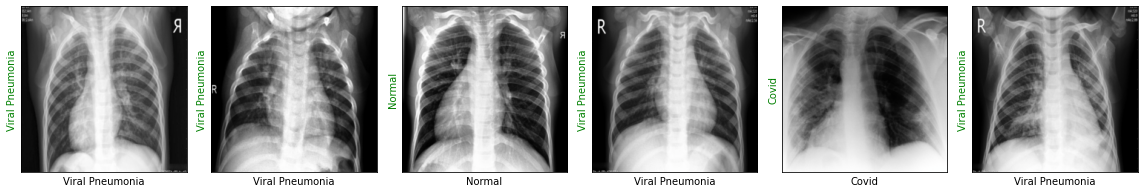

In [6]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

### Create model Resnet(18layer)

In [7]:
resnet18 = torchvision.models.resnet18(pretrained = True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
#hyperparameters
in_features = 512
out_features = 3
lr = 3e-5

resnet18.fc = torch.nn.Linear(in_features=in_features, out_features=out_features)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr = lr) #lr=0.00003

In [9]:
def train(epochs):
    print('Starting training...')
    for e in range(epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        accuracy = 0.
        
        # set model to training phase
        resnet18.train()

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            
           
            if train_step % 6 == 0:
                _, predst = torch.max(outputs, 1)
                accuracy += sum((predst == labels).numpy())
                train_loss += loss.item()
                print('Training at step', train_step)   
                print(f'True Positive ==> {sum(predst == labels)}')
                train_loss /= (train_step + 1)
                show_images(images, labels, predst)
                
        print(f'All True Positive: {accuracy} --- Length Data: {len(dl_train)}') 
        accuracy /= len(dl_train)
        train_loss /= (train_step + 1)
        print(f'Training Loss at step{train_step+1}: {train_loss:.2f}, Accuracy at epoch{e+1}: {accuracy:.2f}')
        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training...
Starting epoch 1/2
Training at step 0
True Positive ==> 1


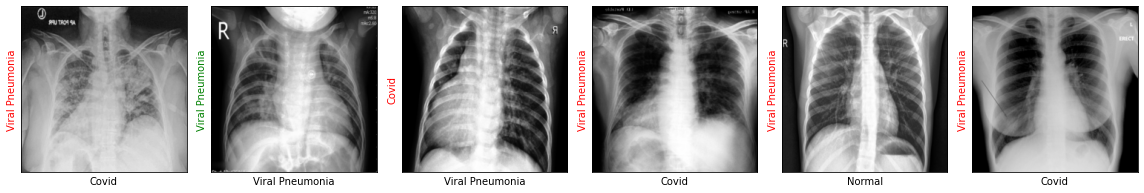

Training at step 6
True Positive ==> 3


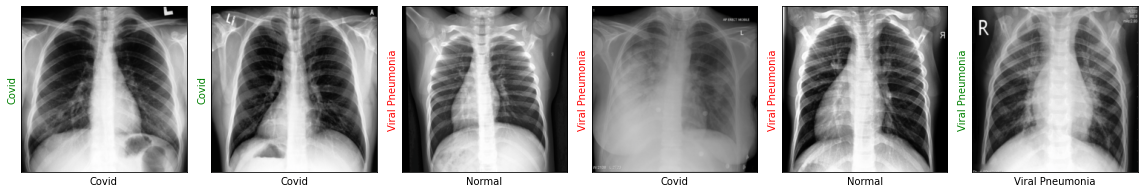

Training at step 12
True Positive ==> 5


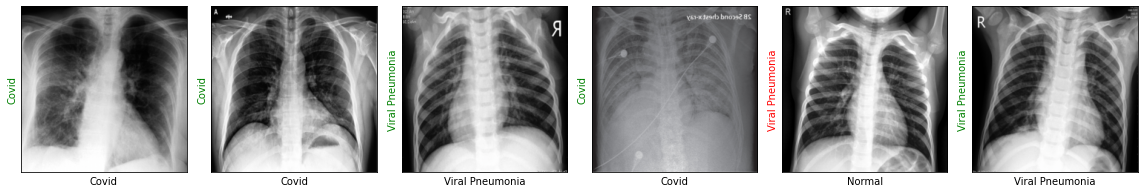

Training at step 18
True Positive ==> 5


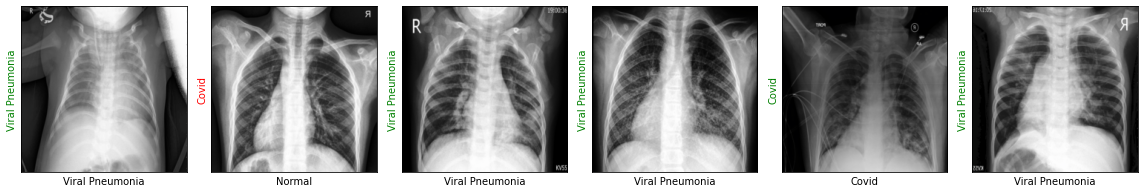

Training at step 24
True Positive ==> 4


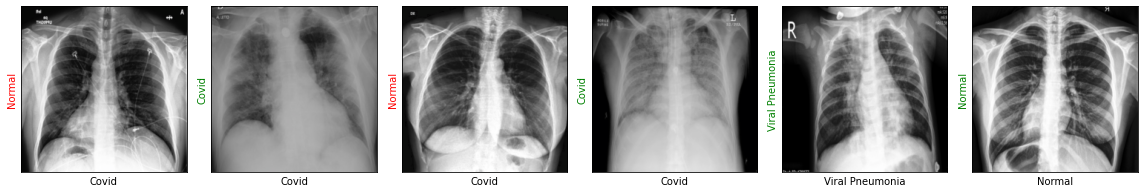

Training at step 30
True Positive ==> 4


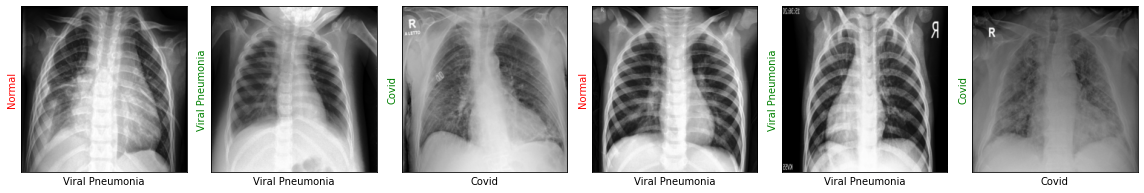

Training at step 36
True Positive ==> 6


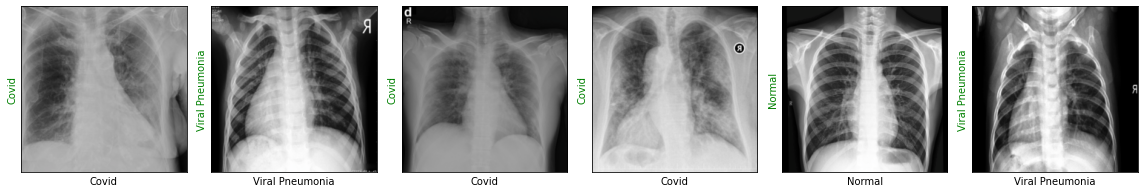

All True Positive: 28.0 --- Length Data: 42
Training Loss at step42: 0.00, Accuracy at epoch1: 0.67
Training Loss: 0.0001
Starting epoch 2/2
Training at step 0
True Positive ==> 5


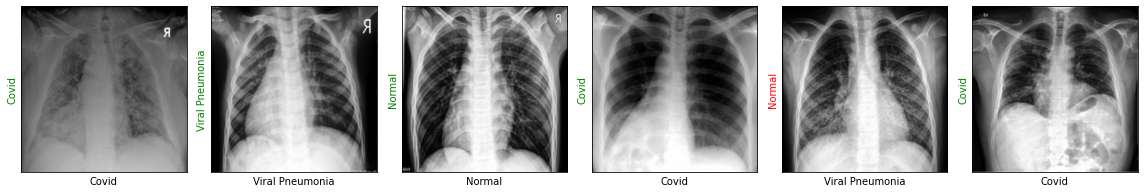

Training at step 6
True Positive ==> 6


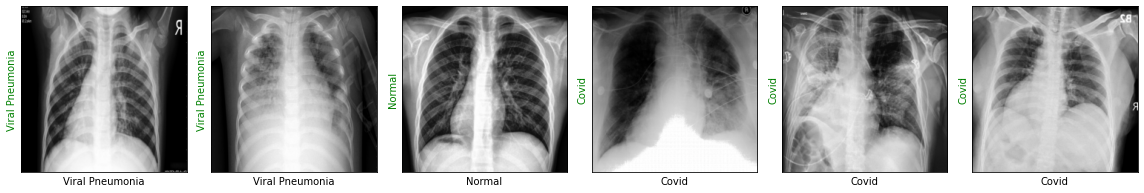

Training at step 12
True Positive ==> 6


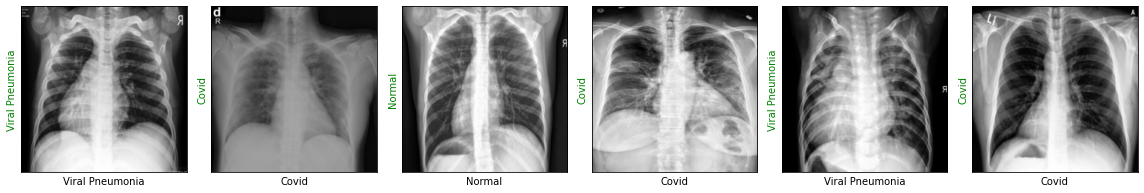

Training at step 18
True Positive ==> 5


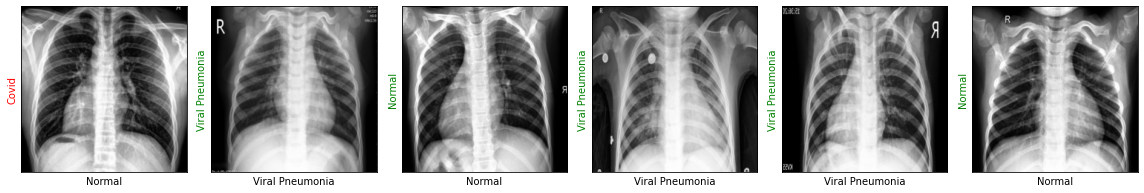

Training at step 24
True Positive ==> 5


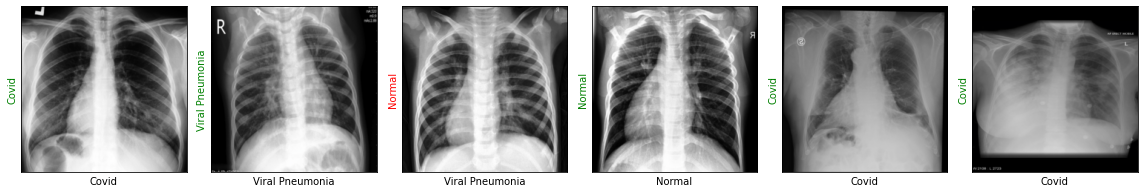

Training at step 30
True Positive ==> 6


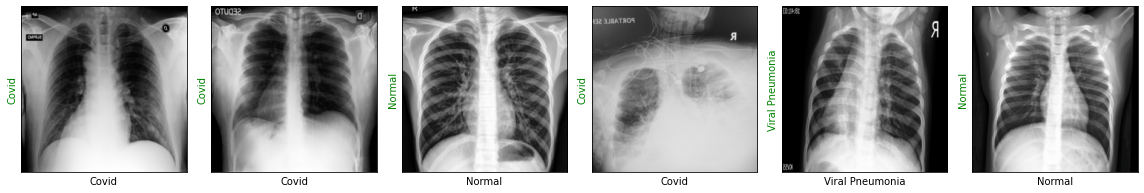

Training at step 36
True Positive ==> 6


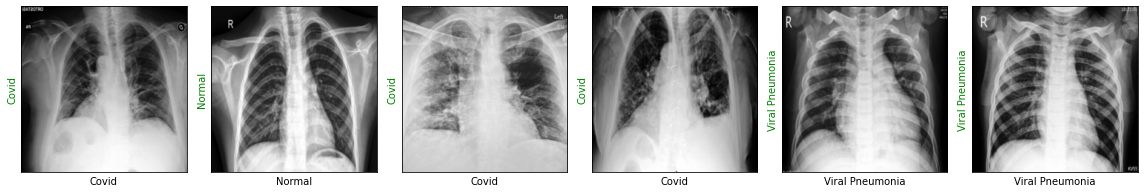

All True Positive: 39.0 --- Length Data: 42
Training Loss at step42: 0.00, Accuracy at epoch2: 0.93
Training Loss: 0.0001
Training complete..


In [10]:
train(epochs=2)

In [14]:
def show_preds():
    resnet18.eval()
    accuracy = 0.
    test_loss = 0.
    for test_step, (images, labels) in enumerate(dl_test):
        outputs = resnet18(images)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        accuracy += sum((preds == labels).numpy())
    show_images(images, labels, preds)
    test_loss /= (test_step + 1)
    accuracy = accuracy/len(test_data)
    print(f'Test Loss: {test_loss:.4f}, Accuracy Test: {accuracy:.4f}')
    
# or

"""
def show_preds():
    resnet18.eval()
    accuracy = 0
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)
"""

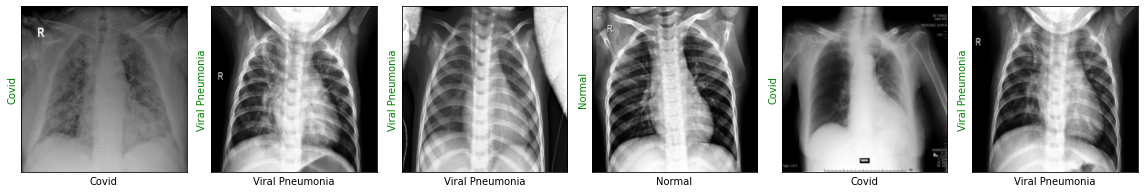

Test Loss: 0.1824, Accuracy Test: 0.9394


In [12]:
show_preds()